In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data()
len(columns),data.shape

(1, 829, 517) (36, 829, 517)


(44, (829, 517, 44))

In [5]:
gc.collect()

15

In [6]:
#show_data(data,columns, 1,480, None)

In [7]:
#show_data2(data,columns)

# cv

In [8]:
n_reg_lookback=42
n_lookforward=1

In [9]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [10]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
ondate_cols=[ u'visitor_lag91', u'visitor_lag182',
       u'visitor_lag364',u'TMAX', u'TMIN', u'TAVG', u'PRCP', u'holiday',
            'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2',
       'weekday1', 'weekday0']
#ondate_cols=[ u'PRCP']
#ondate_cols=columns
ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
ondate_train_test=normalize(ondate_train_test)
ondate_train_test.shape

(15,) 0.0676982591876 123.878437859


(829, 517, 15)

In [12]:
lag_cols=columns

lag_cols=array([u'visitors', u'geo1_visitors_mean', u'geo2_visitors_mean',
       u'station_visitors_mean', u'genre_name_visitors_mean',
       u'day_of_week_visitors_mean', u'visitor_lag7', u'visitor_lag14',
       u'visitor_lag28', u'visitor_lag91', u'visitor_lag182',
       u'visitor_lag364', u'visitor_ma2', u'visitor_ma4', u'visitor_ma7',
       u'visitor_ma14', u'visitor_ma28', u'visitor_ma56', u'visitor_ma112',
       u'visitor_ma224', u'visitor_sma1', u'visitor_sma2', u'visitor_sma3',
       u'visitor_sma4', u'visitor_sma8', u'visitor_sma16',
       u'visitor_sma32'])
#lag_cols=['holiday']
lag_train_test=data[:,:,get_index(lag_cols)].copy()
lag_train_test=normalize(lag_train_test)
lag_train_test.shape

(27,) 2.78591754939 3.02795093092


(829, 517, 27)

In [13]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [14]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [15]:
print K.floatx()

float32


In [16]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [17]:
train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1,478-n_lookforward*7, batchsize=128,valid_split=0.1,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
valid_gen=None
test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward*7,478, batchsize=128,lookback1=n_reg_lookback, lookforward=n_lookforward)

rand split across time
train has 319288 records out of 354812 records
valid has 35524 records out of 354812 records
train has 5803 records out of 5803 records
no valid set


In [18]:
print train_gen.train_steps_per_epoch
print 0 if valid_gen is None else valid_gen.train_steps_per_epoch

2494
0


In [19]:
#show_features(train_gen,ondate_cols,lag_cols,rawy,0,467,filter_fn=lambda u: 'y_0' in u)

In [20]:
lag_input_dim=lag_train_test.shape[-1]
ondate_input_dim=ondate_train_test.shape[-1]
lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)

(27, 15, (1, 15))

In [21]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[3],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 3})

In [26]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.py'>

In [27]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=rrvf.KerasModel("test", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                  ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim,
                  max_epoch=200, use_output_exp=True,
                  params=parameter)
a._make_model()
a.params

(?, 42, 54)


{'activation': 'relu',
 'batch_normalization': False,
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3}

In [28]:
#a.model.summary()
a.model.count_params()

459011

In [29]:
a.fit(train_gen,valid_gen)

Epoch 1/200
2494/2494 [==============================] - 48s 19ms/step - loss: 0.3298 - total_loss: 0.3298 - reg_loss: 0.3298 - val_loss: 0.2737 - val_total_loss: 0.2737 - val_reg_loss: 0.2737
Epoch 2/200
2494/2494 [==============================] - 48s 19ms/step - loss: 0.2880 - total_loss: 0.2880 - reg_loss: 0.2880 - val_loss: 0.2797 - val_total_loss: 0.2797 - val_reg_loss: 0.2797
Epoch 3/200
2494/2494 [==============================] - 48s 19ms/step - loss: 0.2808 - total_loss: 0.2808 - reg_loss: 0.2808 - val_loss: 0.2633 - val_total_loss: 0.2633 - val_reg_loss: 0.2633
Epoch 4/200
2494/2494 [==============================] - 48s 19ms/step - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734 - val_loss: 0.2605 - val_total_loss: 0.2605 - val_reg_loss: 0.2605
Epoch 5/200
2494/2494 [==============================] - 48s 19ms/step - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689 - val_loss: 0.2569 - val_total_loss: 0.2569 - val_reg_loss: 0.2569
Epoch 6/200
2494/2494 [============

<rrvf_model.KerasModel instance at 0x7fa6f6b79c20>

In [30]:
a.traingen=train_gen

In [31]:
a.eval_valid()

best_epochs [5, 8, 7, 6, 4]
0.249087545871 0.249087545871
(1, 0.24908754587099993)


In [32]:
yy_pred=a.predict(300)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [5, 8, 7, 6, 4]
(829, 1) 2.65508988141 (829,)
0.235074936294 0.235074936294
(1, 0.23507493629394721)


In [33]:
traindata=train_gen.get_train()

In [34]:
def predict_train(self):
    X, y, mask,w = self.traingen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X

In [35]:
def predict_test(self):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X

In [67]:
gc.collect()

36432

In [68]:
result=predict_train(a)

best_epochs [5, 8, 7, 6, 4]
(319288, 1) 2.71144301657 (319288, 2)


In [69]:
result[4].keys()

['masky', 'ondatex', 'lagx']

In [70]:
result[4]['lagx'].shape

(319288, 42, 27)

In [71]:
df=pd.DataFrame({'y':result[2][:,0]})

In [72]:
df['pred']=result[0][:,0]
df['dayidx']=result[1][:,1]

In [73]:
df=df.loc[df['y']>0]

In [74]:
df['error']=df['y']-df['pred']
df['error2']=df['error']**2


In [75]:
import rrvf_data

In [76]:
df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)

In [77]:
import seaborn as sns; sns.set(color_codes=True)

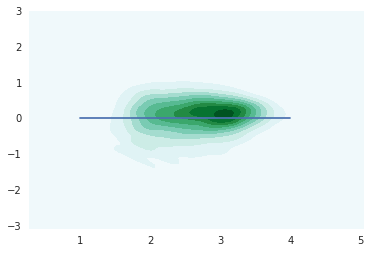

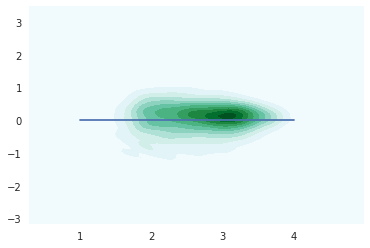

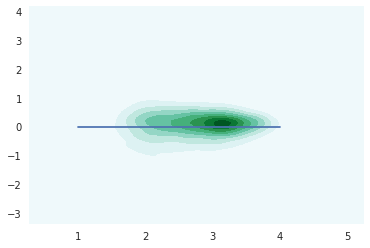

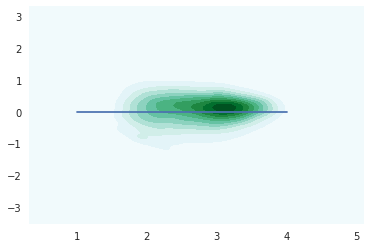

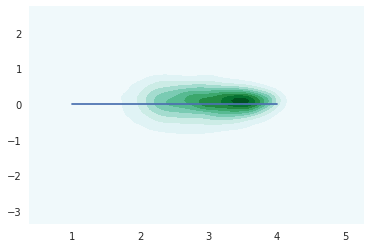

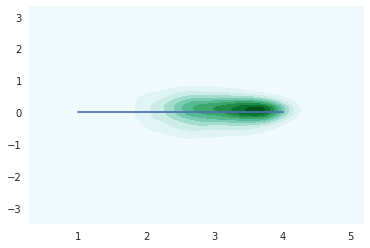

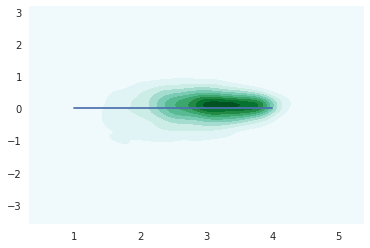

In [78]:
for i in range(1,8):
    plt.plot(np.arange(1,5),np.arange(1,5)*0)
    sns.kdeplot(df['pred'][df['day']==i].values,df['error'][df['day']==i].values, shade=True)
    plt.show()

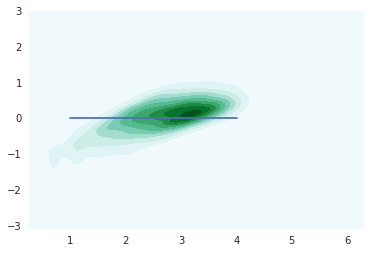

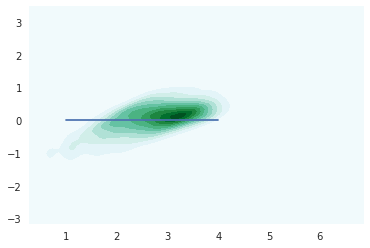

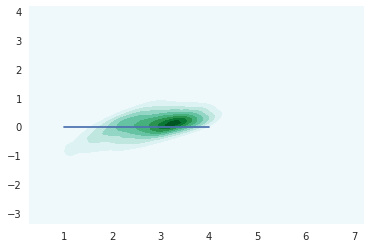

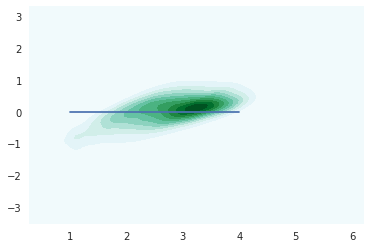

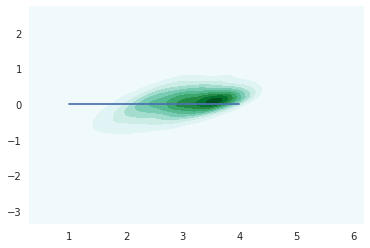

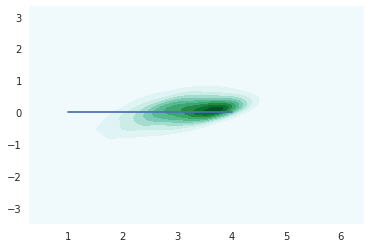

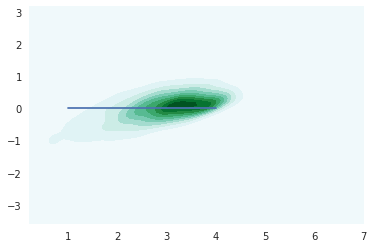

In [47]:
for i in range(1,8):
    plt.plot(np.arange(1,5),np.arange(1,5)*0)
    sns.kdeplot(df['y'][df['day']==i].values,df['error'][df['day']==i].values, shade=True)
    plt.show()

1


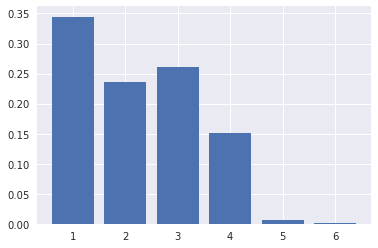

2


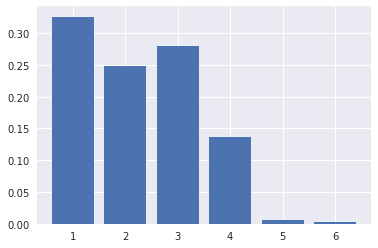

3


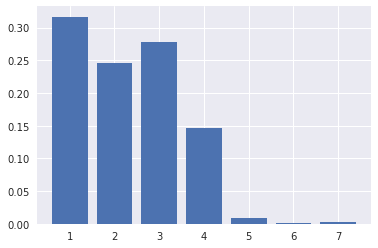

4


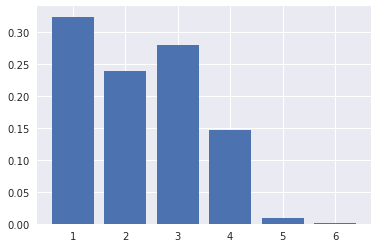

5


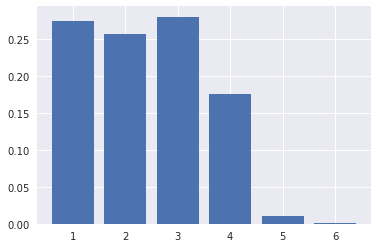

6


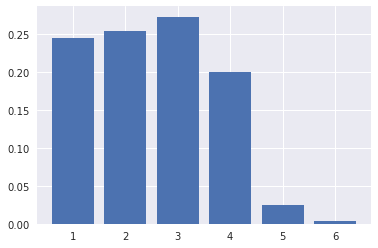

7


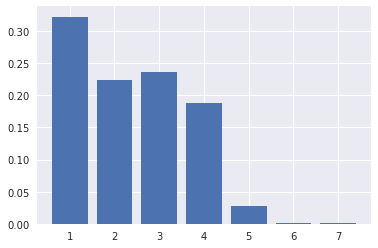

In [48]:
df['tmp']=np.round(df['y'])
for i in range(1,8):
    print i
    s=df[['tmp','error2']][df['day']==i].groupby('tmp').sum().iloc[:,0]
    plt.bar(s.index,s.values/s.sum())
    plt.show()

In [49]:
gc.collect()

73316

In [50]:
df2=df.groupby("dayidx").mean() 

In [51]:
df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())

In [52]:
df2[['day','error2']].groupby('day').median()

error2
day          
1    0.279142
2    0.255151
3    0.242564
4    0.255642
5    0.201401
6    0.207987
7    0.275538

In [53]:
rrvf_data.idx_to_date([477])

array(['2017-04-22'],
      dtype='|S10')

1


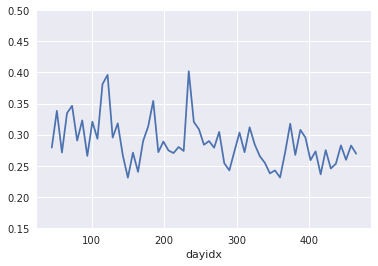

2


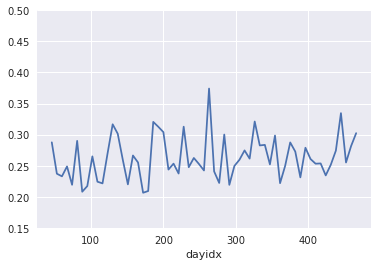

3


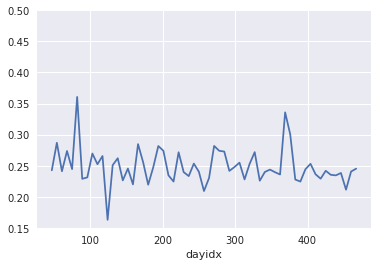

4


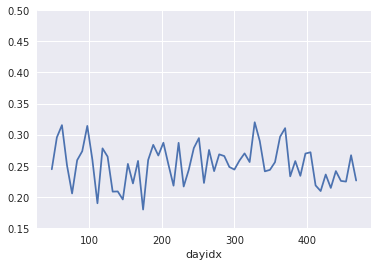

5


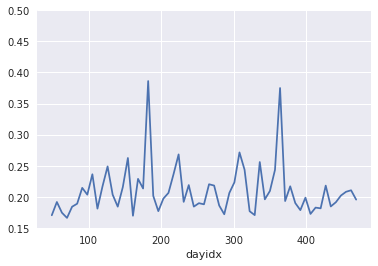

6


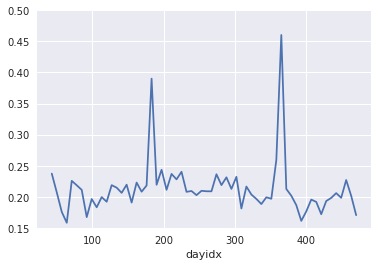

7


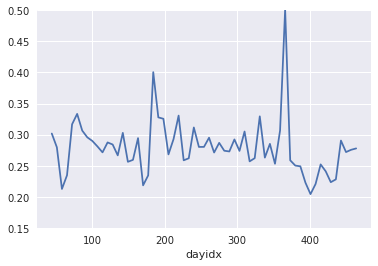

In [54]:
for i in range(1,8):
    print i
    df2[df2['day']==i]['error2'].plot();
    plt.ylim([0.15,0.5])
    plt.show()

In [55]:
df2.sort_values('error2').tail(20)

y      pred     error    error2  day       tmp        date
dayidx                                                                   
331     2.801129  2.857370 -0.056242  0.329425    7  2.788168  2016-11-27
219     2.797809  2.837473 -0.039664  0.330625    7  2.814815  2016-08-07
79      3.118967  3.025452  0.093516  0.333360    7  3.133641  2016-03-20
66      2.615314  2.609664  0.005650  0.334533    1  2.625000  2016-03-07
445     2.601482  2.670018 -0.068536  0.334582    2  2.601974  2017-03-21
369     2.733243  2.772705 -0.039462  0.335804    3  2.747222  2017-01-04
52      2.610565  2.624736 -0.014171  0.338252    1  2.592233  2016-02-22
73      2.623376  2.630781 -0.007405  0.346348    1  2.626168  2016-03-14
185     2.589398  2.607590 -0.018192  0.354308    1  2.585714  2016-07-04
82      2.794039  2.853571 -0.059532  0.360695    3  2.785714  2016-03-23
263     2.403347  2.580787 -0.177440  0.374161    2  2.403571  2016-09-20
364     3.055135  3.036858  0.018278  0.374955    5  3.059845  2016-12-30
115     2.652697  2.687670 -0.034973  0.381363    1  2.636364  2016-04-25
182     3.000507  2.995270  0.005237  0.386176    5  3.014706  2016-07-01
183     3.050652  3.025177  0.025475  0.390074    6  3.036364  2016-07-02
122     2.945648  2.708064  0.237585  0.396173    1  2.955555  2016-05-02
184     2.878745  2.837370  0.041375  0.400560    7  2.852140  2016-07-03
234     2.366544  2.510554 -0.144010  0.401977    1  2.381679  2016-08-22
365     2.675532  2.737186 -0.061654  0.460314    6  2.660650  2016-12-31
366     2.720409  2.733927 -0.013518  0.501605    7  2.713178  2017-01-01

In [56]:
result=predict_test(a)

best_epochs [5, 8, 7, 6, 4]
(5803, 1) 2.7212924921 (5803, 2)


In [57]:
df=pd.DataFrame({'y':result[2][:,0]})

In [58]:
df['pred']=result[0][:,0]
df['dayidx']=result[1][:,1]

In [59]:
df=df.loc[df['y']>0]

In [60]:
df['error']=df['y']-df['pred']
df['error2']=df['error']**2


In [61]:
df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)

In [62]:
df2=df.groupby("dayidx").mean() 

In [63]:
df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())

In [64]:
df2

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.929371 -0.000261  0.265224    7  2017-04-16
472     2.507290  2.564200 -0.056909  0.250833    1  2017-04-17
473     2.661330  2.621382  0.039948  0.278467    2  2017-04-18
474     2.754815  2.696978  0.057837  0.233587    3  2017-04-19
475     2.713762  2.691543  0.022218  0.265968    4  2017-04-20
476     2.999000  2.934556  0.064443  0.173288    5  2017-04-21
477     3.075529  3.103834 -0.028304  0.206892    6  2017-04-22

# time split

In [32]:
train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1,478-n_lookforward*4, 
                  batchsize=128,valid_split=0.0,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward,valid_type=None)
valid_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward*4,478-n_lookforward*2, 
                  batchsize=128,valid_split=0.0,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward,valid_type=None)
test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-n_lookforward,478, batchsize=128,lookback1=n_reg_lookback, lookforward=n_lookforward)

train has 357299 records out of 357299 records
no valid set
train has 1658 records out of 1658 records
no valid set
train has 829 records out of 829 records
no valid set


In [33]:
print train_gen.train_steps_per_epoch
print 0 if valid_gen is None else valid_gen.train_steps_per_epoch

2791
12


In [34]:
#show_features(train_gen,ondate_cols,lag_cols,rawy,0,467,filter_fn=lambda u: 'y_0' in u)

In [35]:
lag_input_dim=lag_train_test.shape[-1]
ondate_input_dim=ondate_train_test.shape[-1]
lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)

(27, 8, (1, 8))

In [36]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[3],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 3})

In [37]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [38]:
backend.clear_session()
set_session(tf.Session(config=config))   
a=rrvf.KerasModel("test", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                  ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim,
                  max_epoch=200,
                  params=parameter)
a._make_model()
a.params

(?, 42, 54)


{'activation': 'relu',
 'batch_normalization': False,
 'l2': 1e-06,
 'loss': 'mean_squared_error',
 'metric': 'mean_squared_error',
 'optimizer': 'adam',
 'patience': 3}

In [39]:
#a.model.summary()
print gc.collect()
a.model.count_params()

454


455425

In [40]:
a.fit(train_gen,valid_gen)

Epoch 1/200
2791/2791 [==============================] - 57s 20ms/step - loss: 0.3199 - total_loss: 0.3199 - reg_loss: 2.5995 - val_loss: 0.2717 - val_total_loss: 0.2717 - val_reg_loss: 0.9499
Epoch 2/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2837 - total_loss: 0.2837 - reg_loss: 2.5131 - val_loss: 0.2499 - val_total_loss: 0.2499 - val_reg_loss: 0.8878
Epoch 3/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 2.4670 - val_loss: 0.2563 - val_total_loss: 0.2563 - val_reg_loss: 0.8219
Epoch 4/200
2791/2791 [==============================] - 57s 20ms/step - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 2.4382 - val_loss: 0.2747 - val_total_loss: 0.2747 - val_reg_loss: 0.8155
Epoch 5/200
2791/2791 [==============================] - 56s 20ms/step - loss: 0.2632 - total_loss: 0.2632 - reg_loss: 2.3925 - val_loss: 0.2606 - val_total_loss: 0.2606 - val_reg_loss: 0.8171


<rrvf_model.KerasModel instance at 0x7f7e885d5d88>

In [41]:
#a.traingen=train_gen

In [42]:
a.eval_valid()

best_epochs [2, 3, 5, 1, 4]
0.258842468217 0.258842468217
(1, 0.25884246821678769)


In [43]:
yy_pred=a.predict(400)

best_epochs [1, 2, 3, 4, 5]
(829, 1) 3.02983174963 (829,)


In [44]:
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

0.190820011306 0.190820011306
(1, 0.19082001130563031)


In [49]:
n_lookforward

1

In [50]:
yy_pred=a.predict(478-n_lookforward-1)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.87643025494 (829,)
0.182698888629 0.182698888629
(1, 0.18269888862869477)


In [51]:
yy_pred=a.predict(478-n_lookforward-2)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.62079328142 (829,)
0.270138534272 0.270138534272
(1, 0.27013853427158546)


In [52]:
yy_pred=a.predict(478-n_lookforward-3)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.60231247107 (829,)
0.243763329538 0.243763329538
(1, 0.24376332953775123)


In [53]:
yy_pred=a.predict(478-n_lookforward-4)
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

best_epochs [1, 2, 3, 4, 5]
(829, 1) 2.52984273246 (829,)
0.278246599289 0.278246599289
(1, 0.27824659928872975)


In [45]:
yy_pred=a.predict(478-n_lookforward)

best_epochs [1, 2, 3, 4, 5]
(829, 1) 3.06015446194 (829,)


In [46]:
rrvf.MSE(yy_pred[2],yy_pred[0],yy_pred[3])

0.209365883356 0.209365883356
(1, 0.20936588335586601)
